Fishing Statistics and Analysis

Stephanie Albornoz, Justin Tung

Both of us enjoy fishing to a certain degree, Stephanie loves visiting North Carolina every summer, her family lives very close to the Ocean close to the intracoastal area and she regularly goes out fishing with her family as a pastime and Justin goes out fishing with his family occasionally during breaks from school. One thing that we have noticed is the inconsistency when we go out fishing, the range of fish we've caught over multiple trips ranges from 0 all the way up to 13. We wanted to understand a little more about the inconsistency and find out potential factors that affected our success (or lack of). These factors included things like: fishing experience, weather, time, method of fishing, etc.

Thankfully for us, the National Oceanic and Atmospheric Administration (NOAA) surveys anglers when they come back from their fishing trips and has publicized the information. Their survey includes lots of data on the factors that we wanted to explore about fishing that we mentioned above.

In our tutorial, we will be analyzing the data provided by the NOAA. We will be observing how different factors affect fishing success, analyzing certain trends in the data and using Machine Learning algorithms to predict whether this year's fishing will improve, and by how much, and what would be the best time to go fish to enjoy this year's summer fishing season.

Part 1. Data collection/curation + parsing:

Tools needed:

In [315]:
import pandas as pd
from random import sample
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import time, timedelta,datetime,date
import math
import statsmodels.formula.api as sm
#Not necessary, just to ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#End not necessary

Introduction to our Data:

We are going to be using one of the NOAA Fisheries official recreational fishing data sets, the data set variables and naming conventions can be pretty confusing, so here is an overlook:

We will be using one of the Trip-Level Data sets, which has records of an angler trip interview. The naming conventions of the Trip-Level Data sets use TRIP_YYYYW, where YYYY is the year, and "W" is the "Wave". For the NOAA, the "Wave" is a 2 month sampling period. Because summer break for most colleges is mid May to late August, we will be using TRIP_20214, TRIP20204, TRIP20194, TRIP20184. This means we will be using wave 4, which contains the months of July/August, of the most recent entries in the dataset from 2018 through 2021. This will also help us since there are a massive amount of entries in the dataset, so specifying certain aspects will allow us to focus more on what we wanted to learn.

Cleaning and Getting Our Data:

First we will read all the CSV files of angler trip surveys performed from 2018-2021 during the months of July/August and put each into a dataframe for cleaning.

In [316]:
tmp_full_df1 = pd.read_csv(r'./trip_20213.csv', low_memory = False)
tmp_full_df2 = pd.read_csv(r'./trip_20203.csv', low_memory = False)
tmp_full_df3 = pd.read_csv(r'./trip_20193.csv', low_memory = False)
tmp_full_df4 = pd.read_csv(r'./trip_20183.csv', low_memory = False)

Then we will edit the temporary dataframes of each year so they only include the data for ocean fishing in the North Carolina area (NC_AREA). We chose to focus on North Carolina since Stephanie has more fishing experience and could potentially relate to the data a bit more. To keep only the data relevant to us, we run this code:

In [317]:
tmp_full_df1 = tmp_full_df1.dropna(subset=['AREA_NC'])
tmp_full_df2 = tmp_full_df2.dropna(subset=['AREA_NC'])
tmp_full_df3 = tmp_full_df3.dropna(subset=['AREA_NC'])
tmp_full_df4 = tmp_full_df4.dropna(subset=['AREA_NC'])
#Since the NOAA marks "1" as the code for ocean fishing, we will only keep this subset
tmp_full_df1 = tmp_full_df1[tmp_full_df1.AREA_NC == "1"]
tmp_full_df2 = tmp_full_df2[tmp_full_df2.AREA_NC == "1"]
tmp_full_df3 = tmp_full_df3[tmp_full_df3.AREA_NC == "1"]
tmp_full_df4 = tmp_full_df4[tmp_full_df4.AREA_NC == "1"]

tmp_full_df1 = tmp_full_df1[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]
tmp_full_df2 = tmp_full_df2[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]
tmp_full_df3 = tmp_full_df3[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]
tmp_full_df4 = tmp_full_df4[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]

In our dataframes above, we have 8 columns of data. We keep track of:

Catch, HRSF, Kod, Time, Gear, Mode_F, FFDAYS12, Year

As we mentioned earlier, fishing is a very inconsistent sport, at least for people who fish casually. Sometimes a person can fish for several hours and catch nothing while another person can fish for a short period of time and catch multiple fish. As a result, the dataset is filled with many entries where people have varying amounts of fish caught. We want to be able to compare the success of different fishermen, even if they fished for different amounts of time. To do this, we will add a new column to each dataframe, and with that column we can see how "successful" an angler was compared to another.

In this tutorial, we will determine success as the amount of fish catched divided by the amount of hours spent to catch said fish, so catching the most amount of fish over the least amount of time implies a higher "success" fishing trip.

In [318]:
tmp_full_df1["succ_hr"] = tmp_full_df1["CATCH"]/ tmp_full_df1["HRSF"]
tmp_full_df2["succ_hr"] = tmp_full_df2["CATCH"]/ tmp_full_df2["HRSF"]
tmp_full_df3["succ_hr"] = tmp_full_df3["CATCH"]/ tmp_full_df3["HRSF"]
tmp_full_df4["succ_hr"] = tmp_full_df4["CATCH"]/ tmp_full_df4["HRSF"]

We are now able to compare how successful each of the anglers' trips were, but we have a new issue to think about. Our dataset is too large to work with, we have too many entries. As much as we would like to include all the entries in the dataset for accuracy, there are simply too many entries each year for us to work with.

In [319]:
print("In fact each of the temporary dataframes sizes are")
print(tmp_full_df1.size,tmp_full_df2.size,tmp_full_df3.size,tmp_full_df4.size)

In fact each of the temporary dataframes sizes are
24651 36549 23859 30105


To combat our problem and for the sake of optimism, we will narrow down our analysis to the most successful fishing trips and ignore any entries that could not be computed from a missing hours fished value. Furthermore, for each dataframe we will only grab the top 1000 performers, with all of their entries at that index together and merge them into a dataframe for the years 2018-2021. This way we will have a much more manageable dataset to work with.

In [320]:
tmp_full_df1,tmp_full_df2= tmp_full_df1.dropna(subset=['succ_hr']),tmp_full_df2.dropna(subset=['succ_hr'])
tmp_full_df3,tmp_full_df4= tmp_full_df3.dropna(subset=['succ_hr']),tmp_full_df4.dropna(subset=['succ_hr'])
tmp_full_df1 = tmp_full_df1.sort_values(by = 'succ_hr')
tmp_full_df2 = tmp_full_df2.sort_values(by = 'succ_hr')
tmp_full_df3 = tmp_full_df3.sort_values(by = 'succ_hr')
tmp_full_df4 =tmp_full_df4.sort_values(by = 'succ_hr')


tmp_full_df1,tmp_full_df2 = tmp_full_df1.iloc[:1000],tmp_full_df2.iloc[:1000]
tmp_full_df3,tmp_full_df4 = tmp_full_df3.iloc[:1000],tmp_full_df4.iloc[:1000]

tmp_dataframes = [tmp_full_df1,tmp_full_df2,tmp_full_df3,tmp_full_df4]
nc_df = pd.concat(tmp_dataframes)
nc_df2 = nc_df.copy()
nc_df

,CATCH,HRSF,kod,TIME,GEAR,MODE_F,FFDAYS12,YEAR,succ_hr
22234,1.0,12.0,wd,1749.0,1.0,8.0,15.0,2021,0.083333
21753,1.0,11.0,wd,1552.0,1.0,8.0,100.0,2021,0.090909
21752,1.0,11.0,wd,1551.0,1.0,8.0,100.0,2021,0.090909
19660,2.0,20.0,we,1814.0,1.0,1.0,25.0,2021,0.100000
19661,2.0,20.0,we,1814.0,1.0,1.0,0.0,2021,0.100000
...,...,...,...,...,...,...,...,...,...
17994,1.0,3.0,we,1231.0,1.0,8.0,200.0,2018,0.333333
16276,1.0,3.0,we,1120.0,1.0,7.0,12.0,2018,0.333333
17995,2.0,6.0,we,1332.0,1.0,8.0,0.0,2018,0.333333
17996,2.0,6.0,we,1333.0,1.0,8.0,0.0,2018,0.333333


Part 2. Data management/representation:

We will also change the names of some of the columns as the NOAA trip variables can be pretty confusing and sometimes do not follow naming conventions. In addition, we will also add the time period that the individuals went fishing. NOAA's data does not directly have this information, but it does have the length of the anglers' trips as well as the time the interview took place, which will allow us to get the period of time of their trip. Knowing this, we will add a column with the time period that the anglers went fishing.

In [321]:
nc_df = nc_df.rename(columns={'CATCH':'num_catched','HRSF':'hrs_fished',
                      'kod':'week/weekday','TIME':'time','GEAR':'gear','MODE_F':'fishing_mode','FFDAYS12':'days_fished', 
                     'YEAR':'year'})
gear_map = {1.0: 'hook & line', 2.0 :'dip net', 3.0: 'cast net', 4.0:'Gill net', 5.0: 'Seine', 6.0: 'Trawl',7.0 : 'Trap',8.0 : 'Spear', 
            9.0 : 'Hand', 10.0 : 
            'Other', 11.0 : 'YoYo (Puerto Rico only)'}
fmode_map = {1.0 : 'Pier, dock',2.0 :'Jetty, breakwater, breachway', 3.0 : 'Bridge, causeway',4.0 : 'Other man-made', 5.0 : 'Beach or bank', 
             6.0 : 'Head boat', 7.0: 'Charter boat', 8.0 : 'Private/Rental boat'}

for i, row in nc_df.iterrows():
    if row["gear"] in gear_map:
        nc_df.at[i,'gear'] = gear_map[row["gear"]]
    if row["fishing_mode"] in fmode_map:
        nc_df.at[i,'fishing_mode'] = fmode_map[row["fishing_mode"]]
    frmt = '%H:%M'
    interview_time = str(int(row["time"]))
    if len(interview_time) <= 3:
        splice = 1
    else:
        splice = 2
    nc_df.at[i,'time'] = time(int(interview_time[:splice]),int(interview_time[splice:]),0)
    
time_start = []
for i, row in nc_df.iterrows():
    time = row["time"]
    dt = datetime.combine(date.today(),time)- timedelta(hours=row["hrs_fished"])
    time_start.append(dt.time())
        
nc_df["starting_time"] = time_start
nc_df

,num_catched,hrs_fished,week/weekday,time,gear,fishing_mode,days_fished,year,succ_hr,starting_time
22234,1.0,12.0,wd,17:49:00,hook & line,Private/Rental boat,15.0,2021,0.083333,05:49:00
21753,1.0,11.0,wd,15:52:00,hook & line,Private/Rental boat,100.0,2021,0.090909,04:52:00
21752,1.0,11.0,wd,15:51:00,hook & line,Private/Rental boat,100.0,2021,0.090909,04:51:00
19660,2.0,20.0,we,18:14:00,hook & line,"Pier, dock",25.0,2021,0.100000,22:14:00
19661,2.0,20.0,we,18:14:00,hook & line,"Pier, dock",0.0,2021,0.100000,22:14:00
...,...,...,...,...,...,...,...,...,...,...
17994,1.0,3.0,we,12:31:00,hook & line,Private/Rental boat,200.0,2018,0.333333,09:31:00
16276,1.0,3.0,we,11:20:00,hook & line,Charter boat,12.0,2018,0.333333,08:20:00
17995,2.0,6.0,we,13:32:00,hook & line,Private/Rental boat,0.0,2018,0.333333,07:32:00
17996,2.0,6.0,we,13:33:00,hook & line,Private/Rental boat,0.0,2018,0.333333,07:33:00


Part 3. 
Exploratory data analysis:

Now that we're done cleaning up our data, we can begin to conduct some analysis on it. 
People have long debated skill versus luck in the sport of fishing. With our data, we can prove or dispute whether fishing is luck or not. We will do this by checking if people who have spent more time fishing have caught more fish in comparison to inexperienced anglers. We will be using the days fished for each angler as a measurement on how experienced they are at fishing, as someone who fished more days in the year will be more experienced than someone who fished less than them.

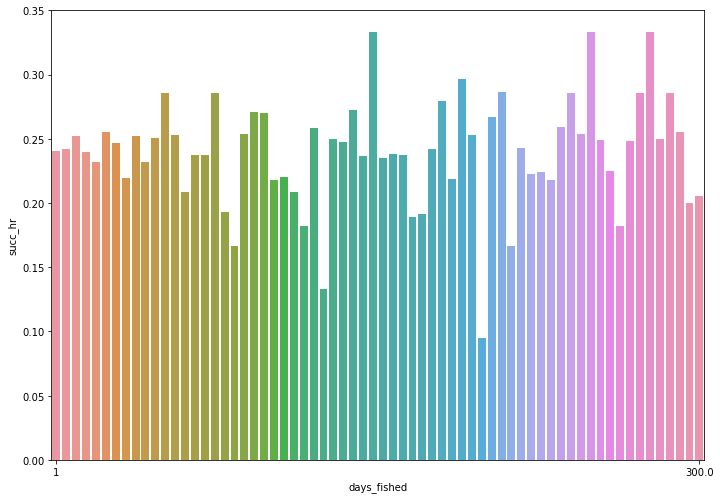

In [322]:
nc_df['days_fished'] = nc_df['days_fished'].replace([998.0],1)
nc_df['days_fished'] = nc_df['days_fished'].replace([999.0],1)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
fig = sns.barplot(y=nc_df["succ_hr"],x=nc_df["days_fished"],ci=None, ax = ax)
size = (len(set(nc_df["days_fished"])))
fished_max = max(set(nc_df["days_fished"]))
set_ticks = plt.xticks([0, size-1], ['1', fished_max])

Sadly as it can be observed, the success rate anglers who fished nearly the maximum number of days in the year were worse or comparable to someone who fished for significantly less days. For example, taking the extremes, people who fished only one day of the year versus three hundred days of the year, the people who fished only one day have a higher success rate. While this seems unintuitive, this gives insight on the fact that while skill is crucial to luring and catching fish, there are many other factors that affect an anglers' success on a fishing trip as well as fishing as a sport. Potential factors affecting success may include: luck, environmental conditions, and fish population.

Since skill does not appear to affect an anglers' success rate, we can analyze another aspect of the data to perhaps find a correlation. Instead, we can look at the method of fishing to see if it affects success as it could be that the way that these anglers fished could have a significant impact on how successful their trips were. 

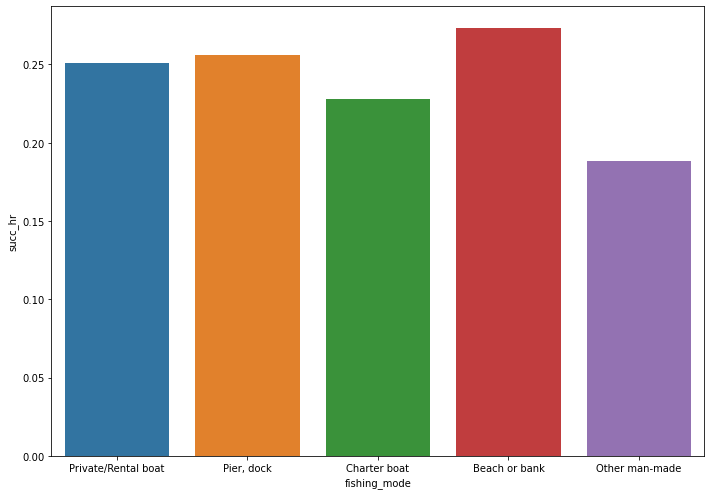

In [323]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
fig = sns.barplot(y=nc_df["succ_hr"],x=nc_df["fishing_mode"],ci=None, ax = ax)

At a glance, besides other man-made fishing spots, the method of fishing all produce similar results in terms of success rate, approximately .25 fish caught per hour. This means that it takes on average, 4 hours to catch one fish for nearly every method. It seems likely that the method for fishing does not have that large of an effect on the amount of fish an angler would catch. This also holds up with the idea that there are many factors that affect the success rate, so we would not see a specific factor drastically changing success.


Instead, let's explore the data in regards to how successful people were each year, we will see what were the most common rates at which people caught fish by the hour. This way we can also see the density at which people most commonly caught fish.

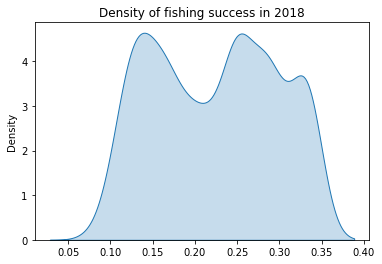

In [324]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2018:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2018')

As we can see in 2018, the most commonly dense group of success rates was between 0.10-0.15, implying that it would take someone around 6-10 hours to catch a single fish, and then another peak being a success rate of 0.25-0.30, implying that it would take the angler 3-4 hours approximately to catch a fish. 

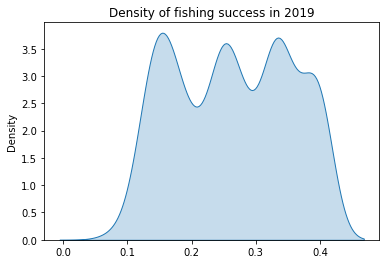

In [325]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2019:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2019')

In 2019, the most commonly dense group of success rates was between 0.10-0.20, implying that it would take someone around 5-10 hours to catch a single fish, and then another peak being a success rate of 0.25, implying that it would take the angler approximately 4 hours to catch a fish, then finally we see another peak in density between 0.3-0.4 success rate, implying that another most common group would catch a fish after approximately 2.5-3 hours.

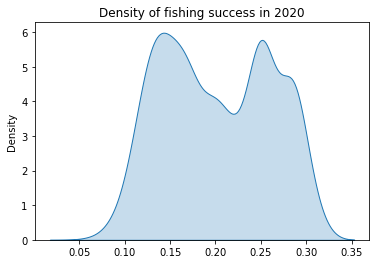

In [326]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2020:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2020')

Then in 2020 it was the most commonly dense group of success rates at around 0.15, implying that it would take someone around 7 hours to catch a single fish, and then another peak being a success rate of a little over 0.25, implying that it would take the angler close to 4 hours approximately to catch a fish.

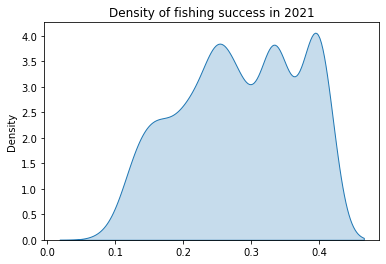

In [327]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2021:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2021')

Last year in 2021, the most commonly dense group of success rates was approximately at 0.25, implying that it would take someone around 4 hours to catch a single fish, and then another peak being a success rate of at around 0.35, implying that it would take the angler approximately 3 hours until they caught a fish, and then another peak at a little over a rate of 0.4, implying it would
take the angler around 2.5 hours to catch one fish.

As we can see, certain years were better in terms of anglers' success on fishing trips than other years. Specifically, in 2021 there was a very noticeable shift of density towards higher success rates compared to the years before it. Another thing to note is that there were also shifts in previous years towards the most common densities of success rate. If we combine all of our density graphs we get:

                            OLS Regression Results                            
Dep. Variable:                succ_hr   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     97.41
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.02e-22
Time:                        00:43:36   Log-Likelihood:                 4242.0
No. Observations:                4000   AIC:                            -8480.
Df Residuals:                    3998   BIC:                            -8467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.3810      2.394     -9.768      0.0

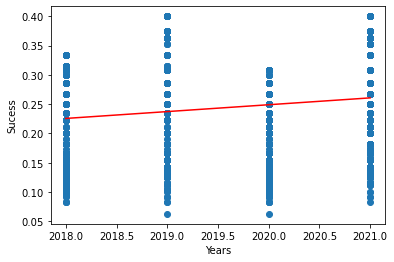

In [328]:
x_axis = np.array(nc_df["year"]).reshape(-1,1)
y_axis = nc_df["succ_hr"]
linear_reg = LinearRegression().fit(x_axis,y_axis)
plt.scatter(nc_df["year"],nc_df["succ_hr"])
prediction = linear_reg.predict(x_axis)
plt.plot(x_axis, prediction, color = "red")
plt.xlabel("Years")
y = plt.ylabel("Sucess")
average_increase = linear_reg.coef_
info = sm.ols(formula = "succ_hr ~ year",data= nc_df).fit()
print(info.summary())

As a reminder, our null hypothesis is that there is a relation between years and the success rate of anglers. Since the P-Value in the Linear Regression is 0, we can reject the null hypothesis, meaning that there is indeed a relation between the year anglers fished and their success.

This is significant because this means that there is relation between year and successful fishing trips. For us, this would generally explain the variance in the amount of fish that we catch every year. There are too many factors that may affect this, so we will not be exploring that in this tutorial.

Another Idea to Explore:

As much as the two of us like to fish, fishing with large crowds is not as enjoyable for us. Crowds make it difficult to find a nice spot to fish and makes it much more difficult to maneuver our reels. Thankfully, since we were able to calculate the time of anglers' trips, we are able to observe the most popular times to fish each year, and we can get a "period of time" were people went to fish.

In [329]:
nc_df["starting_time"]
setsy = set()
all_periods = []
for i, row in nc_df.iterrows():
    start_time,ending_time = row["starting_time"], row["time"]
    start_hr,end_hr = start_time.hour,ending_time.hour
    setsy.add(start_hr)
    setsy.add(end_hr)
    period = (start_hr,end_hr)
    all_periods.append(period)

nc_df["period_of_fishing"] = all_periods
nc_df

,num_catched,hrs_fished,week/weekday,time,gear,fishing_mode,days_fished,year,succ_hr,starting_time,period_of_fishing
22234,1.0,12.0,wd,17:49:00,hook & line,Private/Rental boat,15.0,2021,0.083333,05:49:00,"(5, 17)"
21753,1.0,11.0,wd,15:52:00,hook & line,Private/Rental boat,100.0,2021,0.090909,04:52:00,"(4, 15)"
21752,1.0,11.0,wd,15:51:00,hook & line,Private/Rental boat,100.0,2021,0.090909,04:51:00,"(4, 15)"
19660,2.0,20.0,we,18:14:00,hook & line,"Pier, dock",25.0,2021,0.100000,22:14:00,"(22, 18)"
19661,2.0,20.0,we,18:14:00,hook & line,"Pier, dock",0.0,2021,0.100000,22:14:00,"(22, 18)"
...,...,...,...,...,...,...,...,...,...,...,...
17994,1.0,3.0,we,12:31:00,hook & line,Private/Rental boat,200.0,2018,0.333333,09:31:00,"(9, 12)"
16276,1.0,3.0,we,11:20:00,hook & line,Charter boat,12.0,2018,0.333333,08:20:00,"(8, 11)"
17995,2.0,6.0,we,13:32:00,hook & line,Private/Rental boat,0.0,2018,0.333333,07:32:00,"(7, 13)"
17996,2.0,6.0,we,13:33:00,hook & line,Private/Rental boat,0.0,2018,0.333333,07:33:00,"(7, 13)"


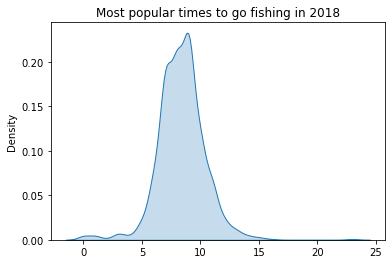

In [330]:
times = []
for i, row in nc_df.iterrows():
    if row["year"] == 2018:
        start,end = row["period_of_fishing"]
        times.append(start)
kde = sns.kdeplot(times,shade=True).set(title='Most popular times to go fishing in 2018')

As we can see in 2018, the most popular time to fish was at 8-9 AM. This makes relative sense because of the density of fish caught in 2018, which was around .1-.15 and .25-.30 which means that people were out on the water for around 6-10 hours or 3-4 hours. People usually do not want to stay out on the water when it gets dark. As a result, we can see that many anglers depart early in the morning so that they have ample amounts of time to catch fish.


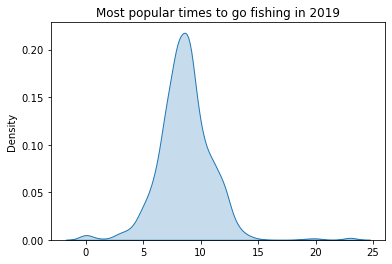

In [331]:
times = []
for i, row in nc_df.iterrows():
    if row["year"] == 2019:
        start,end = row["period_of_fishing"]
        times.append(start)
kde = sns.kdeplot(times,shade=True).set(title='Most popular times to go fishing in 2019')

Compared to the previous year of 2018, the peak fishing time in 2019 has stayed relatively the same, with the peak fishing time being around 8 AM. Comparing the density of fishing success in 2019 and 2018, the results make sense, as fishing success density did not change very much from 2018 to 2019. One thing to note is that there was a slightly higher density of .25 success per hour in 2019, which can explain the slight shift of time from 7-8 AM to 8 AM, since people can leave a little later in the morning and still have decent success fishing.


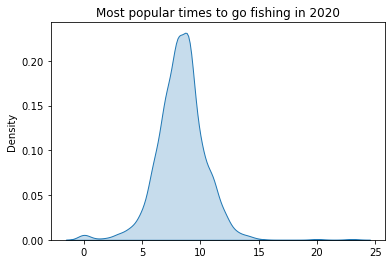

In [332]:
times = []
for i, row in nc_df.iterrows():
    if row["year"] == 2020:
        start,end = row["period_of_fishing"]
        times.append(start)
kde = sns.kdeplot(times,shade=True).set(title='Most popular times to go fishing in 2020')

From the 2020 fishing time chart above, we can see that the most popular times have still been relatively similar to previous years, with more people leaving around 7 AM up to the peak time of leaving at around 9 to 10 AM. From the density chart of 2020, there was a significant increase in success rate, as the density of people who had around .25 fish per hour jumped from a density of around 3.5 to a density of 6. Since the density increased this much, people could catch significantly more fish during their trips. This would allow the anglers to leave at a larger window of time without decreasing their chances of fishing success, which is what we see in the graph above.

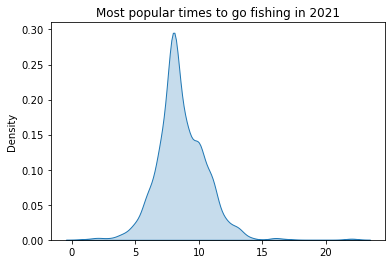

In [333]:
times = []
for i, row in nc_df.iterrows():
    if row["year"] == 2021:
        start,end = row["period_of_fishing"]
        times.append(start)
kde = sns.kdeplot(times,shade=True).set(title='Most popular times to go fishing in 2021')

In 2021, the density of fishing success for anglers decreased somewhat, with many anglers catching either .25 fish per hour, .35 fish per hour, and .4 fish per hour, each at a density of around 4. This is a decrease from the previous year, where the density of catching fish was around 6. As we can see in the popular fishing times chart above, the most popular time to leave is much more sharp in comparison to previous years. The peak was at 7 AM, which means that in order to combat the lower fishing success rates, anglers had to once again wake up earlier in order to increase their chances of catching fish.

And if we combine all of our fishing times together, and fit a linear regression line on them:

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.825
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.177
Time:                        00:43:38   Log-Likelihood:                -8630.9
No. Observations:                4000   AIC:                         1.727e+04
Df Residuals:                    3998   BIC:                         1.728e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -72.3085     59.802     -1.209      0.2

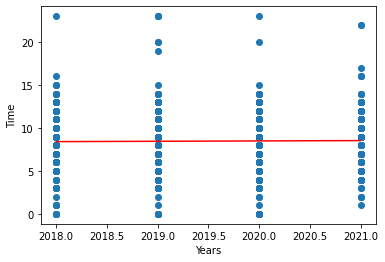

In [334]:
all_times = []
for i, row in nc_df.iterrows():
    start,end = row["period_of_fishing"]
    all_times.append(start)
    
x_axis = np.array(nc_df["year"]).reshape(-1,1)
y_axis = all_times
linear_reg = LinearRegression().fit(x_axis,y_axis)
plt.scatter(nc_df["year"],all_times)
prediction = linear_reg.predict(x_axis)
plt.plot(x_axis, prediction, color = "red")
plt.xlabel("Years")
y = plt.ylabel("Time")
average_increase = linear_reg.coef_
tmpdf = pd.DataFrame({'time':all_times, 'years' :list(nc_df["year"])})
info = sm.ols(formula = "time ~ years",data= tmpdf).fit()
print(info.summary())

We can see from the graph that the average time to go fishing has not changed over the years at all. The linear regression line has stayed at a steady 7 AM time from the years 2018-2021. With a p-value of 0.177, we can also not reject the null hypothesis that the year has no relation to the most popular time to fish.

Unfortunately for us, it appears that there is no optimal time to fish. If we fish at a time when other people are not, we would be severely sacrificing our chances of success catching fish since the average success rate of anglers is one fish every few hours. It seems that the only alternatives for us are to either find our own secluded spots for fishing, or renting a boat out on the water away from other fishermen.

Part 4. 
Hypothesis testing, training our data to make predictions:

We will use linear regression to using our variables of how successful anglers wear each year, train the regression model on training data, and produce predictions for our testing data:

In [335]:
X = nc_df2['YEAR']
Y = nc_df2['succ_hr']
X = X.transpose()
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = .5, random_state=13)
x_train_copy, x_test_copy, y_train_copy, y_test_copy = x_train, x_test, y_train, y_test 
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)

line = LinearRegression()
line.fit(x_train, y_train)
y_pred = line.predict(x_test)

And our predictions for our test data would look like:

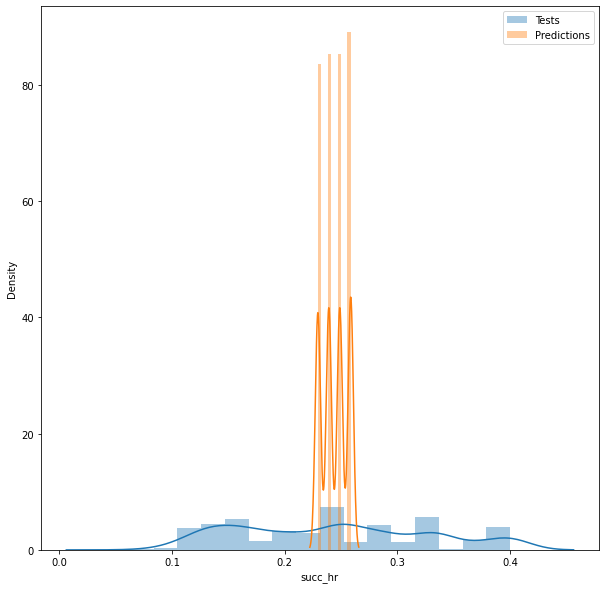

In [336]:
f, ax = plt.subplots(figsize=(10,10))
x = sns.distplot(y_test,label="Tests", ax=ax)
y = sns.distplot(y_pred,label="Predictions", ax=ax)
legend = ax.legend()

Further on, if we decided to cross validate these results with another regression algorithm, say a tree regressor one, we get the following results:

In [344]:
regressor = DecisionTreeRegressor()
regressor_tree = regressor.fit(x_train,y_train)
y_pred = regressor_tree.predict(x_test)

And if we visualize the predictions of the regressor tree:

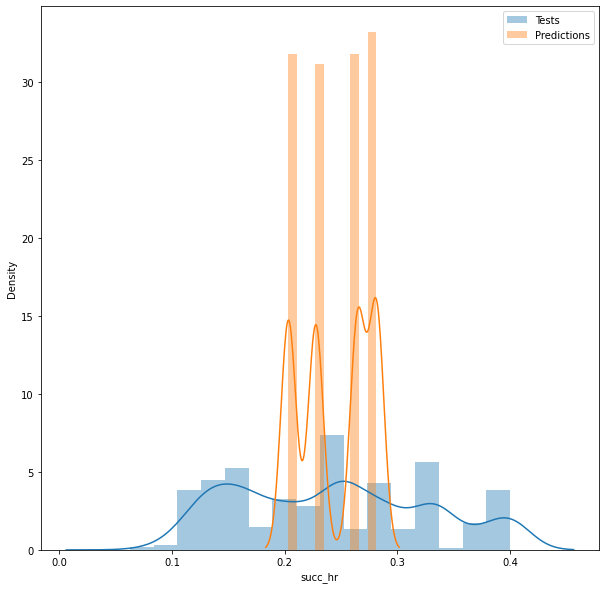

In [345]:
f, ax = plt.subplots(figsize=(10,10))
x = sns.distplot(y_test,label="Tests", ax=ax)
y = sns.distplot(y_pred,label="Predictions", ax=ax)
legend = ax.legend()

After using both Linear regression, and Decission Tree regressor to predict next years fisihing success, it doesn't appear that a linear regression line would fit either of our prediction too well however, so we will check the coefficients of correlation with 
a r2 score to see how related the independent and dependent variable are:

In [346]:
r_score = r2_score(y_test, y_pred)
print("r squared score: ", r_score)

r squared score:  0.15191994128743602


The R squared score shows how related the independent and dependent variable are. Since we got such a low score of .028 as our score, it shows that the year has little to no effect on the success rate of anglers' fishing trips. This is understandable as fishing has a lot of factors involved in it, such as environment, fishing populations, overfishing, pollution, and between others. So for us sadly, that means that we should be looking for other factors in fishing that may affect success rather than year.

Part 5. Conclusion:

Conclusion

Fishing is a very popular outdoor recreational sport. A large part of the enjoyment of fishing is the amount of fish that people catch while on the trip. We wanted to learn about whether certain factors affected the successfulness of fishing trips in order to potentially maximize the amount of enjoyment we get when we go fishing. The factors that we explored was using how successful people were in other years to predict our next year that we go fishing as well as the time that we should go out fishing. There are many other factors that we did not explore in this tutorial that may correlate to a more successful fishing trip. For the future for anyone interested, they can perform their own analysis on the NOAA's fishing data using our tutorial as a basis and with further research not available on the NOAA database, survey for fishing popluation, pollution, and environment factors that would be beneficial for a more through analysis. 